# "সম্ভাব্যতা তত্ত্ব ও বায়েসিয়ান পরিসংখ্যান: Probability theory and Bayesian statistics"
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: bayesian statistics
- metadata_key2: probability

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import inv
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize
import random

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, ExpSineSquared, WhiteKernel
from sklearn.model_selection import GridSearchCV

import sklearn.gaussian_process as gp
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

## বায়াসের উপপাদ্য 
   
নতুন প্রমাণ / ডেটা পেলে, কোন বিষয়ে আমাদের আগের অনুমান পরিবর্তন করার উপায় 

$$p\left(H|e\right)=\frac{p\left(e|H\right)p\left(H\right)}{p\left(e\right)}$$

![bayes-rule](images/bayes-rule.png)

Link:
* [Chamok Hasan's lecture](https://www.youtube.com/watch?v=rZW0iYPJurU)
* [Bayes' rule Image](https://medium.com/@mark.rethana/bayesian-statistics-and-naive-bayes-classifier-33b735ad7b16)

## সহজ সরল গাউসিয়ান প্রসেস: Gaussian Process 101

গাউসিয়ান প্রসেস (GP) অন্য পাঁচ দশটা মেশিন লার্নিং মডেল এর মত একটা মডেল।  প্রবাবিলিটি থিওরির কারনে এটাকে রহস্যময় মনে হতে পারে।  এই পোস্টে GP এর বেসিক উদাহরণ সহ আলোচনা করবো।  এটাকে ব্যবহার করে আমরা প্রেডিকশন করবো।  

গাউসিয়ান প্রসেস (GP) খুব প্রয়োজনীয় একটা মডেল। এটার রয়েছে নানাবিধ ব্যবহার, যেমন ফোরকাস্টিং, অপ্টিমাইজেশান, অনিশ্চয়তা নির্ণয় । এখানে GP এর বেসিক নিয়ে আলোচনা করবো এবং সাথে থাকবে উদাহরণ। 

একটা ছোট ডাটাসেট দিয়ে শুরু করা যাক।  একটি মডেল ট্রেইন করবো, যার ইনপুট X, আর আউটপুট Y.
Python table

ডাটা কে প্লট করি।
scatter plot
মডেল ট্রেইন করা মডেল নতুন X এর জন্য Y এর ভ্যালু বলে দিতে পারবে।


In [16]:
rng = np.random.RandomState(0)

df = pd.DataFrame()
df['num_nodes'] = [15 * random.random() for i in range(50)]
df['run_time'] = [random.random()*10 + 14 for i in range(df.shape[0])] + df['num_nodes']

ডাটা এর একটা অংশ দেখে নেই

In [17]:
df.head()

,num_nodes,run_time
0,10.011123,33.932683
1,0.662198,16.171634
2,4.387310,27.419947
3,4.756711,27.799672
4,2.588224,23.200371


In [18]:
scaled_features = StandardScaler().fit_transform(df.values)
scaled_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

# Prepare train test data
columns = ['num_nodes', 'run_time']
target = 'run_time'
adf = scaled_df[columns].copy()
#adf = adf[0:100]
Y = adf[target]
Y = Y.ravel()
del adf[target]

X = np.atleast_2d(adf['num_nodes']).T

x_train = X
y_train = Y
# Making test set
x_test = np.atleast_2d([5, -1, 2, -.6]).T



কার্নেল (Kernel) দুটি ডাটা পয়েন্টের ভিতর কতখানি মিল আছে সেটা বের করে।

কার্নেল এর প্রকার ভেদে মডেলের রেজাল্ট পরিবর্তন হয়।


In [19]:
kernel_choice = 'RBF' #st.radio("Kernel", ('RBF', 'Matern'))

kernels = {
    'RBF': 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
    'Matern': 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
}


In [46]:
dfs = []
for kernel_choice in kernels.keys():
    gp = GaussianProcessRegressor(kernel=kernels[kernel_choice], n_restarts_optimizer=20)
    gp.fit(x_train, y_train)
    y_pred, cov = gp.predict(x_test, return_std=True)
        
    cdf = pd.DataFrame({'y_pred': y_pred, 'x_test': x_test.flatten()})
    cdf['kernel'] = kernel_choice
    dfs.append(cdf)
    
df = pd.concat(dfs)
df

,y_pred,x_test,kernel
0,-5.408512e-237,5.0,RBF
1,1.420753e+01,-1.0,RBF
2,-2.557457e+00,2.0,RBF
3,-3.853391e+01,-0.6,RBF
0,1.797096e-23,5.0,Matern
1,-5.276632e-01,-1.0,Matern
2,7.095403e-02,2.0,Matern
3,8.133148e-02,-0.6,Matern


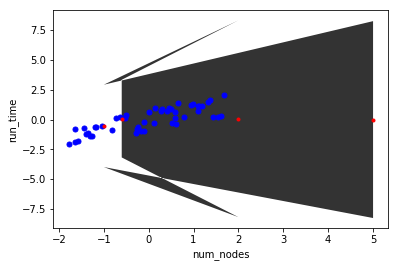

In [47]:
def get_plot(x_train, y_train, x_test, y_pred, cov, y_test=None):

    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    fig = plt.figure()

    plt.plot(x_train, y_train, 'b.', markersize=10, label='Observations')

    plt.plot(x_test, y_pred, 'r.', label='Prediction')

    plt.fill(np.concatenate([x_test, x_test[::-1]]),
             np.concatenate([y_pred - 1.9600 * cov,
                            (y_pred + 1.9600 * cov)[::-1]]),
             alpha=.8, fc='k', ec='None', label='95% confidence interval')

    plt.xlabel('num_nodes')
    plt.ylabel('run_time')
    return fig

kernel_choice = 'Matern'
y_pred = df_result[df_result['kernel_choice']==kernel_choice]['y_pred'].values[0]
cov = df_result[df_result['kernel_choice']==kernel_choice]['cov'].values[0]
figobj = get_plot(x_train, y_train, x_test, y_pred, cov)

In [45]:
import altair as alt
input_dropdown = alt.binding_select(options=['RBF','Matern'])
selection = alt.selection_single(fields=['kernel'], bind=input_dropdown, name='Kernel ')
color = alt.condition(selection,
                    alt.Color('kernel:N', legend=None),
                    alt.value('lightgray'))
alt.Chart(df).mark_point().encode(
    x='x_test:Q',
    y='y_pred:Q',
    color=color,
    #tooltip='run_time:N'
).add_selection(selection)


alt.Chart(...)

GP কার্নেল ও নয়েস স্কেল ঠিক করে দিতে হয়। এটা করতে হয়  কিছু ডেটা ব্যবহার করে।  এই প্রসেসটাকে hyperparameter tuning বলা হয়ে থাকে। L-BGFS-B অপটিমাইজার দিয়ে এই hyperparameter ঠিক করা হয়।   

In [22]:
kernel = C() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)
kernel.hyperparameters

[Hyperparameter(name='k1__k1__constant_value', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False),
 Hyperparameter(name='k1__k2__length_scale', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__noise_level', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False)]

অপটিমাম প্যারামিটার ভ্যালু:

In [23]:
gp = GaussianProcessRegressor(kernel, n_restarts_optimizer=20)
gp.fit(x_train, y_train)
gp.kernel_

0.00316**2 + Matern(length_scale=0.639, nu=1.5) + WhiteKernel(noise_level=0.266)

# New heading